# Simon's Problem

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

import warnings
warnings.simplefilter('ignore')

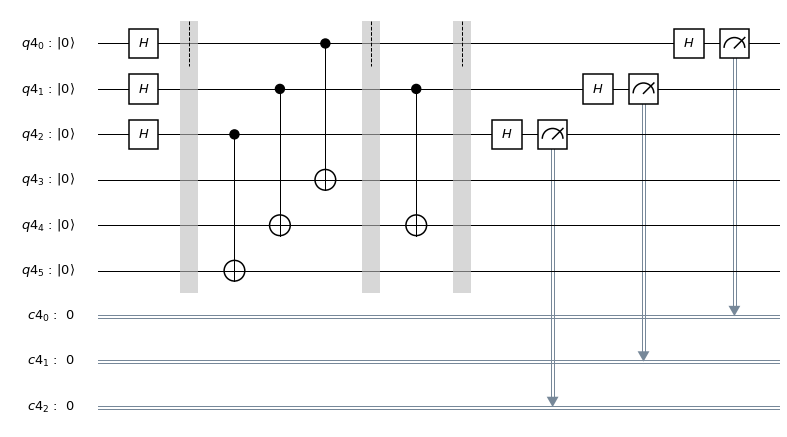

In [42]:
n = 3

qr = QuantumRegister(n*2) # 4 qubit register
cr = ClassicalRegister(n) # 1 classical register
circ = QuantumCircuit(qr, cr) # Quantum Circuit on q

for i in range(0, n):
    circ.h(qr[i])

circ.barrier()

for i in range(0, n):
    circ.cx(qr[i], qr[n+i])
circ.barrier()
secret = ""
for i in range(0, n):
    secret += str(random.randint(0, 10000)%2)

s = "010" #temp val

#xor s to register 2 (temp).
for i, c in enumerate(s):
    if c == '1':
        circ.cx(qr[i], qr[n+i])

# TO DO, rest of black box. maybe

circ.barrier()

for i in range(0, n):
    circ.h(qr[i])
    circ.measure(qr[i], cr[i])

circ.draw(output='mpl')

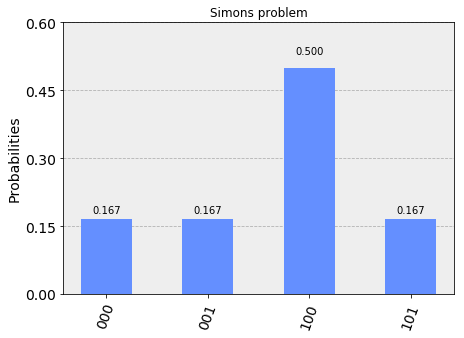

In [59]:
simulator = Aer.get_backend('qasm_simulator')

result = execute(circ, simulator, shots=n*2).result()
count = result.get_counts(circ)
plot_histogram(count, title='Simons problem')

In [44]:
count

{'001': 2, '100': 1, '101': 3}

The following two cells have code to solve system of linear equations to figure out s. Code is latter repeated for blackbox witouth cnots of the qubits in superposition and ancilla bits.

In [50]:
A = np.zeros((n*2, n))
B = np.zeros((n*2))
j = 0
for m, c in count.items():
    for g in range(c):
        for i, v in enumerate(m):
            A[j][i] = v
        j = j + 1
s= np.linalg.lstsq(A, B.T)
A, B, s

(array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]]),
 array([0., 0., 0., 0., 0., 0.]),
 (array([0., 0., 0.]),
  array([], dtype=float64),
  2,
  array([2.74615755, 1.20773289, 0.        ])))

In [51]:
A2 = np.zeros((len(count), n))
B2 = np.zeros(len(count))
j2 = 0
for m, c in count.items():
    for k, v in enumerate(m):
        A2[j2][k] = int(v)*c
    j2 = j2 + 1
A2, B2.T
s2= np.linalg.lstsq(A2, B2.T)
A2, B2, s2

(array([[0., 0., 2.],
        [1., 0., 0.],
        [3., 0., 3.]]),
 array([0., 0., 0.]),
 (array([0., 0., 0.]),
  array([], dtype=float64),
  2,
  array([4.54138127, 1.54138127, 0.        ])))

In [48]:
s22 = np.linalg.solve(A2, B2)
s22

LinAlgError: Singular matrix

In [14]:
regs = 2

q = QuantumRegister(regs*2) # qubit register
c = ClassicalRegister(regs) # classical register
circ = QuantumCircuit(q, c) # Quantum Circuit on q
secret = None
number = None

    
def gen_rand():
    number = 0
    secret = [None] * regs
    j = regs-1
    for i in range(0, regs):
        rand = random.randint(0, 9)%2
        number += rand*(2**i)
        print("rand is %d" %rand)
        secret[j] = str(rand) #binary string
        j -= 1
    #if number == 0:
    #    secret = []
    #    j = regs-1
    #    return gen_rand()

    return number, secret
    
#generating random secret


number, secret = gen_rand()
print("binary is: "+"{0:b}".format(number))
print("number is %d" %number)
for i in range(0, len(secret)):
    print(">> secret[%d] is %s" %(i,secret[i]))
#print("secret[0] is %c" %secret[0])
print(">> secret is: "+''.join(secret)+"\n")

for i in range(0, regs):
    circ.h(q[i])
    #print("Hadamard on q[%d]" % i)

#begining of blackbox
circ.barrier()
for i in range(0, regs):
    circ.cx(q[i], q[i+regs])
    #copying first half of registers to second half
circ.barrier()
length = len(secret)
    
for i in range(0, length):
    if secret[i] == '1':
        circ.x(q[i+regs])
        circ.cx(q[i], q[i+regs])


    
# for i in range(0, regs):
    #if i % 2 == 0:
     #   circ.x(q[i])
    #else:
     #   circ.cx(q[i-1], q[i])
#    0
circ.barrier()
print(circ)

rand is 1
rand is 0
binary is: 1
number is 1
>> secret[0] is 0
>> secret[1] is 1
>> secret is: 01

              ┌───┐ ░            ░            ░ 
q7_0: |0>─────┤ H ├─░────────■───░────────────░─
         ┌───┐└───┘ ░        │   ░            ░ 
q7_1: |0>┤ H ├──────░───■────┼───░────────■───░─
         └───┘      ░   │  ┌─┴─┐ ░        │   ░ 
q7_2: |0>───────────░───┼──┤ X ├─░────────┼───░─
                    ░ ┌─┴─┐└───┘ ░ ┌───┐┌─┴─┐ ░ 
q7_3: |0>───────────░─┤ X ├──────░─┤ X ├┤ X ├─░─
                    ░ └───┘      ░ └───┘└───┘ ░ 
 c7_0: 0 ═══════════════════════════════════════
                                                
 c7_1: 0 ═══════════════════════════════════════
                                                
